In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.patches as patches
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', 150)
from IPython.display import Image

# modeling libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from statsmodels.formula.api import logit

# utilities
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, auc
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.pipeline import Pipeline
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

In [3]:
df = pd.read_csv('Data/result1.csv').drop('Unnamed: 0', axis='columns')

# Converting 'zone' column into a categorical column 
df['zone'] = pd.Categorical(df['zone'])

In [4]:
str_cols = df.columns[(df.dtypes=='object') | (df.dtypes=='category')]
df_num = df[df.columns[~df.columns.isin(list(str_cols))]]
df_str = pd.get_dummies(df[str_cols].drop(['player_name', 'events', 'description'],axis='columns'))
df_all = pd.concat([df_num, df_str], axis='columns')
X = df_all.drop('strike_result', axis='columns')
y = df_all['strike_result']


# Feature Selection

In [5]:
def calculate_vif_(X, thresh=5.0):
    """
    Function to calculate and eliminates any independent features that are correlated with each other and
    will print those features out. The function will return the remaining dataframe free of multicollinearity.
    
    X (dataframe): dataframe of independent variables
    thresh (float): threshold value to determine how correlated features can be before removing them
    """
    
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [6]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    """
    Function that identifies features that are too highly correlated with the dependent variable and
    returns a list of features to keep.
    
    df1 (Dataframe): The independent variable(s).
    target (Series): the dependent variable
    """
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [7]:
# Identifying features that are too correlated to the dependant variable using the IV method and picking 
# features that have an IV more than 0.001

final_iv, IV = data_vars(X, y)
var_name  = IV.sort_values('IV', ascending=False)
X = X[list(var_name.VAR_NAME[var_name['IV'] > 0.001])]
X.columns

Index(['zone_14.0', 'zone_11.0', 'zone_5.0', 'zone_13.0', 'zone_4.0',
       'zone_6.0', 'zone_2.0', 'zone_12.0', 'zone_8.0', 'zone_9.0', 'zone_7.0',
       'zone_1.0', 'zone_3.0', 'plate_z', 'balls', 'pitch_number', 'pfx_z',
       'effective_speed', 'pitch_name_4-Seam Fastball', 'vy0', 'plate_x', 'ay',
       'release_speed', 'az', 'pitch_name_Curveball'],
      dtype='object')

In [8]:
# eliminating features that are collinear with each other
X = calculate_vif_(X, thresh=5.0)

dropping 'vy0' at index: 19
dropping 'zone_14.0' at index: 0
dropping 'release_speed' at index: 20
dropping 'effective_speed' at index: 16
dropping 'ay' at index: 18
dropping 'plate_z' at index: 12
dropping 'pitch_number' at index: 13
dropping 'az' at index: 16
Remaining variables:
Index(['zone_11.0', 'zone_5.0', 'zone_13.0', 'zone_4.0', 'zone_6.0',
       'zone_2.0', 'zone_12.0', 'zone_8.0', 'zone_9.0', 'zone_7.0', 'zone_1.0',
       'zone_3.0', 'balls', 'pfx_z', 'pitch_name_4-Seam Fastball', 'plate_x',
       'pitch_name_Curveball'],
      dtype='object')


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
m = sm.Logit(y_train, X_train).fit()
m.summary()

Optimization terminated successfully.
         Current function value: 0.525759
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          strike_result   No. Observations:                27293
Model:                          Logit   Df Residuals:                    27276
Method:                           MLE   Df Model:                           16
Date:                Sun, 12 Jan 2020   Pseudo R-squ.:                  0.2281
Time:                        08:47:57   Log-Likelihood:                -14350.
converged:                       True   LL-Null:                       -18589.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
zone_11.0                     -1.2374      0.059    -20.896      0.000      -1.353      -1.121
zone_5.0                       1.9964      0.071     28.302      0.000       1.858       2.135
zone_13.0                     -0.9262      0.049    -18.776      0.000      -1.023      -0.830
zone_4.0                       1.8239      0.083     22.082      0.000       1.662       1.986
zone_6.0                       2.2291      0.077     28.908      0.000       2.078       2.380
zone_2.0                       2.1773      0.093     23.491      0.000       1.996       2.359
zone_12.0                     -0.1735      0.053     -3.293      0.001      -0.277      -0.070
zone_8.0                       1.7825      0.070     25.323      0.000       1.644       1.920
zone_9.0                       1.9280      0.071     27.230      0.000       1.789       2.067
zone_7.0                       1.5495      0.081     19.076      0.000       1.390       1.709
zone_1.0                       1.6122      0.090     17.839      0.000       1.435       1.789
zone_3.0                       2.0740      0.093     22.334      0.000       1.892       2.256
balls                          0.0766      0.015      5.194      0.000       0.048       0.106
pfx_z                         -0.1769      0.032     -5.477      0.000      -0.240      -0.114
pitch_name_4-Seam Fastball    -0.0559      0.043     -1.307      0.191      -0.140       0.028
plate_x                       -0.4434      0.024    -18.171      0.000      -0.491      -0.396
pitch_name_Curveball          -0.4742      0.064     -7.368      0.000      -0.600      -0.348
==============================================================================================
"""

In [13]:
# Removing columns that aren't statistically significant
drop_cols = X.columns[m.pvalues >= 0.05]
X = X.drop(drop_cols, axis='columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Retrain model
m = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.526218
         Iterations 6


In [14]:
# Finding the best threshold value to decide between a strike and a hit by testing 10 values
prob = np.arange(1,10,.02)/10
max_val = 0

for i in prob:
    y_pred = m.predict(X_train).apply(lambda x: 1 if x>i else 0)
    train_score = roc_auc_score(y_train, y_pred)
    if train_score > max_val:
        max_val = train_score
        max_i = i
print('best threshold value =',max_i)
print('corresponding training auc score = ', max_val)

best threshold value = 0.7560000000000006
corresponding training auc score =  0.7729147633892859


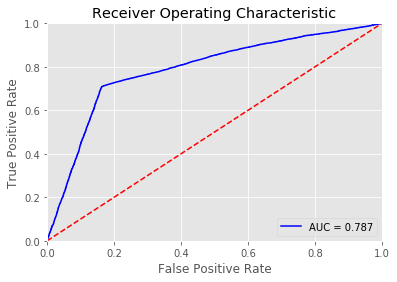

optimal threshold value = 0.7557082790872585


In [15]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
preds = m.predict(X_train)
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
print('optimal threshold value =', optimal_threshold)

# Performance

In [16]:
y_test_pred = m.predict(X_test).apply(lambda x: 1 if x>optimal_threshold else 0)
print('testing auc score = ', roc_auc_score(y_test, y_test_pred))

testing auc score =  0.7707598938491513


# Conclusion

With the final modeling finished, we can now use the logistic regression weighting results to determine the most important features, and make informative decisions how which pitcher is overvalued, and likewise, which ones are undervalued.

In [17]:
np.exp(m.params.sort_values(ascending=False)).index
# feature importance for stats logisitic regression
pd.DataFrame(np.exp(m.params.sort_values(ascending=False)), columns=['feature importance'])


,feature importance
zone_6.0,9.422992
zone_2.0,8.872649
zone_3.0,7.984899
zone_5.0,7.404507
zone_9.0,6.822729
zone_4.0,6.046533
zone_8.0,6.020497
zone_1.0,4.984599
zone_7.0,4.743863
balls,1.071807


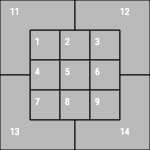

In [32]:
Image(filename= 'Data\zones.png')

Notice how the most influential features end up being ones that are related to zone areas. This would indicate that certain areas have a higher probability of being a strike and that a pitcher's accuracy is also important (refer to the diagram above to identify locations of each zone). Although this is an interesting result, it is not a practical strategy to only throw to zone 6 as the batter will eventually catch on. We will only be looking at pfx_z since it is the most influential and practical feature to pick out good pitchers. Using this this knowledge of what features make a successful pitcher, we can identify undiscovered talented pitchers. In addition to finding the most talented pitchers, we have to keep in mind the cost so we will need data on their current salaries. In this case, we will only be looking at pitchers who are paid under 1 million.m

In [20]:
starting_pitchers_names = df.player_name.loc[df['inning']==1].unique()
df3 = (df[df.player_name.isin(starting_pitchers_names)].groupby('player_name')
         .agg({'pfx_z':'mean',
               'plate_x':'mean',
               'ay':'mean',
               'az':'mean', 
               'vy0':'mean',
               'release_speed':'mean',
               'strike_result':'mean', 
               'inning':'count'})
         .sort_values(by=['pfx_z'], ascending=False)
         .reset_index()
          )

df_salaries = pd.read_excel('Data/salary.xlsx')
sp_salaries = df_salaries[['Name', 'Team', 'Avg Annual']][df_salaries['POS']=='SP']
df_all = pd.merge(df3, sp_salaries, left_on='player_name', right_on='Name', how='right').dropna()
df_all['Avg Annual'] = df_all['Avg Annual'].astype(int)
#df_all = df_all[df_all['Avg Annual']<=1000000]

''

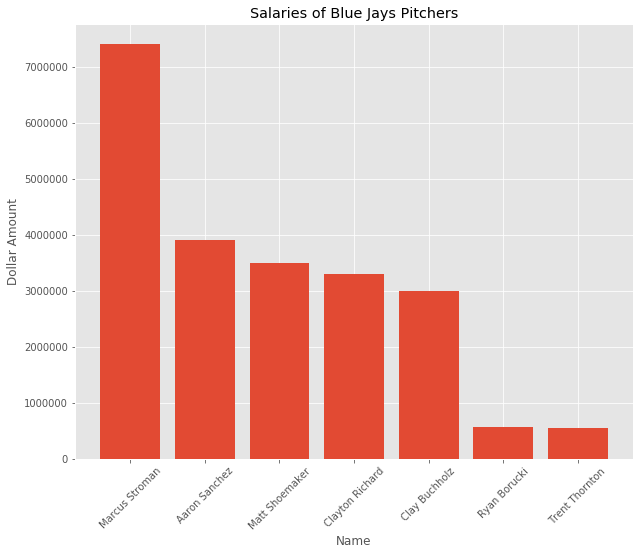

In [21]:
bj_pitcher_salary = df_salaries[(df_salaries.Team=='TOR ') & (df_salaries.POS=='SP')]
plt.figure(figsize=[10,8])
plt.title('Salaries of Blue Jays Pitchers')
plt.xlabel('Name')
plt.ylabel('Dollar Amount')
plt.bar(bj_pitcher_salary.Name, bj_pitcher_salary['Avg Annual'])
plt.xticks(rotation=45)
#plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor");
;

In [22]:
(df[df.player_name.isin(list(bj_pitcher_salary.Name))]
     .groupby('player_name')
     .agg({'pfx_z':'mean', 'strike_result':'mean', 'inning':'count'})
     .sort_values(by=['pfx_z'], ascending=False))

,pfx_z,strike_result,inning
player_name,,,
Trent Thornton,0.623450,0.517442,172
Aaron Sanchez,0.483208,0.508571,175
Marcus Stroman,0.348979,0.576471,170
Clayton Richard,0.245683,0.545455,77


In [25]:
# Highest pfx_z
df_all.sort_values(by=['pfx_z'], ascending= False).set_index('player_name').head(5)

,pfx_z,plate_x,ay,az,vy0,release_speed,strike_result,inning,Name,Team,Avg Annual
player_name,,,,,,,,,,,
Chris Paddack,1.121038,-0.034676,26.565494,-16.975289,-130.555692,89.791160,0.657459,181.0,Chris Paddack,SD,555000
Blake Snell,1.120256,0.070185,28.395799,-16.318547,-134.003529,92.150625,0.612500,160.0,Blake Snell,TB,10000000
Lucas Giolito,1.112967,0.292511,25.916894,-17.416477,-130.295408,89.553049,0.585366,164.0,Lucas Giolito,CWS,573000
Andrew Cashner,1.074511,-0.294734,24.915442,-19.005848,-128.350931,88.335204,0.576531,196.0,Andrew Cashner,BAL,8000000
J.A. Happ,1.067922,0.438034,25.685451,-18.801338,-131.776421,90.627941,0.470588,68.0,J.A. Happ,NYY,17000000


In the table above, we can see a list of pitchers who are much more cost efficient and effective as pitchers compared to some of the players on the Blue Jays roster. Chris Paddack, Lucas Giolito, Eduardo Rodrguez, and  	Trevor Richards are all starting pitchers who fit the description and are a fraction of what Marcus Stroman is being paid. If the Blue Jays can find an opportunity to obtain these players, they will definitely be able to see an improvement with the number of strikes they can get in a game, resulting in more wins.